In [161]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Import Libaries

In [162]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

import tensorflow as tf
import keras
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import string
import time
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer

from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras import activations
from tensorflow.keras import Input
from PIL import Image
#used for creating Progress Meters or Progress Bars
from tqdm import tqdm

import glob
from IPython import display
import collections

import wordcloud
from wordcloud import WordCloud, STOPWORDS


#Load data

In [163]:
#Load Images
images='/content/drive/MyDrive/Images'
all_imgs = glob.glob(images + '/*.jpg',recursive=True)
print("The total images present in the dataset: {}".format(len(all_imgs)))

The total images present in the dataset: 8091


In [164]:
all_imgs = all_imgs[:500]

<ipython-input-165-7c3f6abe441f>:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  ax.imshow(imageio.imread(image), cmap=None)


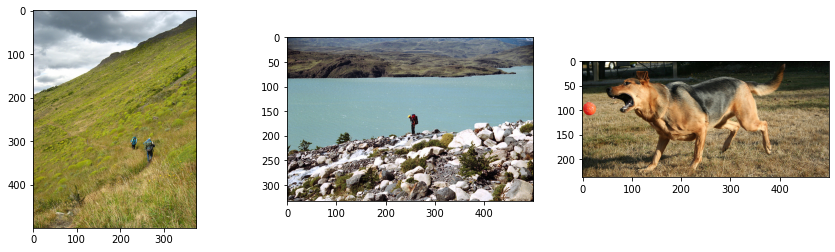

In [165]:
import imageio

Display_Images = all_imgs[0:3]
figure, axes = plt.subplots(1,3)
figure.set_figwidth(15)
for ax, image in zip(axes, Display_Images):
  ax.imshow(imageio.imread(image), cmap=None)

In [166]:
text_file = '/content/drive/MyDrive/captions.txt'

In [167]:
#Load Caption
def load_doc(filename):
    open_file = open(text_file, 'r', encoding='latin-1' ) 
    text = open_file.read() 
    open_file.close()
    return text
doc = load_doc(text_file)
print(doc[:300])

image,caption
1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg,A girl going into a wooden building .
1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg,A little girl climbing


In [168]:
img_path = '/content/drive/MyDrive/Images/'

all_img_id = [] 
all_img_vector = [] 
annotations = [] 

counter = 0 # initialize the counter variable

with open('/content/drive/MyDrive/captions.txt' , 'r') as fo:
    next(fo) 
    for line in fo :
        if counter == 2500: # break the loop when the counter reaches 500
            break
        split_arr = line.split(',')
        all_img_id.append(split_arr[0])
        annotations.append(split_arr[1].rstrip('\n.')) #removing out the \n.
        all_img_vector.append(img_path+split_arr[0])
        counter += 1 # increment the counter variable

df = pd.DataFrame(list(zip(all_img_id, all_img_vector,annotations)),columns =['ID','Path', 'Captions'])     
df

,ID,Path,Captions
0,1000268201_693b08cb0e.jpg,/content/drive/MyDrive/Images/1000268201_693b0...,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,/content/drive/MyDrive/Images/1000268201_693b0...,A girl going into a wooden building
2,1000268201_693b08cb0e.jpg,/content/drive/MyDrive/Images/1000268201_693b0...,A little girl climbing into a wooden playhouse
3,1000268201_693b08cb0e.jpg,/content/drive/MyDrive/Images/1000268201_693b0...,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,/content/drive/MyDrive/Images/1000268201_693b0...,A little girl in a pink dress going into a woo...
...,...,...,...
2495,1463732807_0cdf4f22c7.jpg,/content/drive/MyDrive/Images/1463732807_0cdf4...,A boy on a playground swing strikes a medatati...
2496,1463732807_0cdf4f22c7.jpg,/content/drive/MyDrive/Images/1463732807_0cdf4...,A boy on a swing wearing a green shirt is maki...
2497,1463732807_0cdf4f22c7.jpg,/content/drive/MyDrive/Images/1463732807_0cdf4...,A young boy makes a meditational pose on a swing
2498,1463732807_0cdf4f22c7.jpg,/content/drive/MyDrive/Images/1463732807_0cdf4...,Boy in green shirt sitting in swing with eyes ...


In [169]:
#check total captions and images present in dataset
print("Total captions present in the dataset: "+ str(len(annotations)))
print("Total images present in the dataset: " + str(len(all_imgs)))

Total captions present in the dataset: 2500
Total images present in the dataset: 500


In [170]:
#Create the vocabulary & the counter for the captions
vocabulary = [word.lower() for line in annotations for word in line.split()]
val_count = Counter(vocabulary) 
val_count

Counter({'a': 3883,
         'child': 123,
         'in': 1098,
         'pink': 38,
         'dress': 27,
         'is': 587,
         'climbing': 80,
         'up': 92,
         'set': 7,
         'of': 412,
         'stairs': 2,
         'an': 167,
         'entry': 1,
         'way': 6,
         'girl': 273,
         'going': 8,
         'into': 91,
         'wooden': 24,
         'building': 25,
         'little': 149,
         'playhouse': 2,
         'the': 1091,
         'to': 228,
         'her': 73,
         'cabin': 1,
         'black': 212,
         'dog': 472,
         'and': 511,
         'spotted': 1,
         'are': 191,
         'fighting': 2,
         'tri-colored': 2,
         'playing': 115,
         'with': 480,
         'each': 27,
         'other': 41,
         'on': 712,
         'road': 23,
         'white': 207,
         'brown': 146,
         'spots': 2,
         'staring': 2,
         'at': 225,
         'street': 52,
         'two': 302,
         'dogs': 12

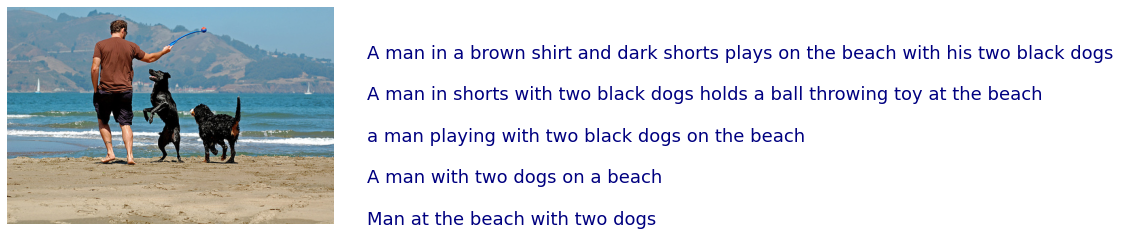

In [171]:
def caption_with_img_plot(image_id, frame) :
  capt = ("\n" *2).join(frame[frame['ID'] == image_id].Captions.to_list())
  fig, ax = plt.subplots()
  ax.set_axis_off()
  idx = df.ID.to_list().index(image_id)
  im =  Image.open(df.Path.iloc[idx])
  w, h = im.size[0], im.size[-1]
  ax.imshow(im)
  ax.text(w+50, h, capt, fontsize = 18, color = 'navy')
caption_with_img_plot(df.ID.iloc[289], df)

#Clean data

In [172]:
#data cleaning
rem_punct = str.maketrans('', '', string.punctuation)
for r in range(len(annotations)) :
  line = annotations[r]
  line = line.split()

  # converting to lowercase
  line = [word.lower() for word in line]

  # remove punctuation from each caption and hanging letters
  line = [word.translate(rem_punct) for word in line]
  line = [word for word in line if len(word) > 1]

  # remove numeric values
  line = [word for word in line if word.isalpha()]

  annotations[r] = ' '.join(line)

In [173]:
#add the <start> & <end> token to all those captions as well
annotations = ['<start>' + ' ' + line + ' ' + '<end>' for line in annotations]

#Create a list which contains all the path to the images
all_img_path = all_img_vector

In [174]:
##list contatining captions for an image
annotations[0:5]

['<start> child in pink dress is climbing up set of stairs in an entry way <end>',
 '<start> girl going into wooden building <end>',
 '<start> little girl climbing into wooden playhouse <end>',
 '<start> little girl climbing the stairs to her playhouse <end>',
 '<start> little girl in pink dress going into wooden cabin <end>']

#Data preprocess

In [175]:
# Creating the tokenizer
top_word_cnt = 5000
tokenizer = Tokenizer(num_words = top_word_cnt+1, filters= '!"#$%^&*()_+.,:;-?/~`{}[]|\=@ ',
                      lower = True, char_level = False, 
                      oov_token = 'UNK')

In [176]:
# Creating word-to-index and index-to-word mappings.
tokenizer.fit_on_texts(annotations)

#transform each text into a sequence of integers
train_seqs = tokenizer.texts_to_sequences(annotations)

In [177]:
# We add PAD token for zero
tokenizer.word_index['PAD'] = 0
tokenizer.index_word[0] = 'PAD'

In [178]:
# Pad each vector to the max_length of the captions  store it to a vairable

train_seqs_len = [len(seq) for seq in train_seqs]

longest_word_length = max(train_seqs_len)

cap_vector= tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding= 'post', maxlen = longest_word_length,
                                                          dtype='int32', value=0)
print("The shape of Caption vector is :" + str(cap_vector.shape))

The shape of Caption vector is :(2500, 29)


In [179]:
# creating list to store preprocessed images and setting up the Image Shape

preprocessed_image = []
IMAGE_SHAPE = (299, 299)

In [180]:
#checking image format 

tf.keras.backend.image_data_format()

'channels_last'

In [181]:
for img in all_imgs[0:5] :
    img = tf.io.read_file(img, name=None)
    img = tf.image.decode_jpeg(img, channels=0)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    preprocessed_image.append(img)

Shape after resize :  (299, 299, 3)
Shape after resize :  (299, 299, 3)
Shape after resize :  (299, 299, 3)
Shape after resize :  (299, 299, 3)
Shape after resize :  (299, 299, 3)


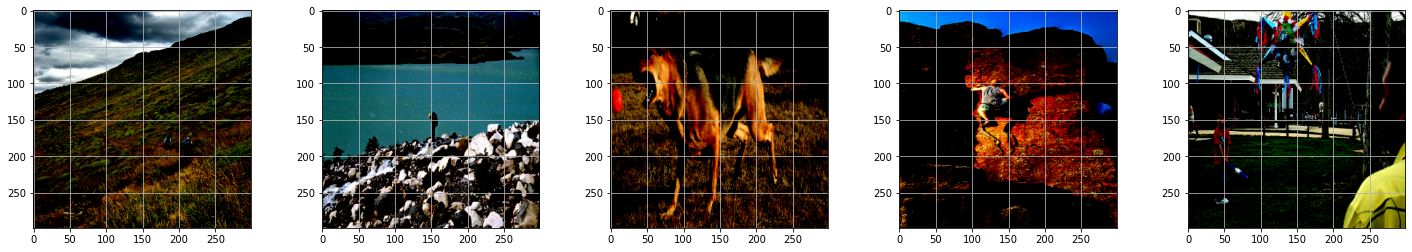

In [182]:
# checking first five images post preprocessing
Display_Images = preprocessed_image[0:5]
figure, axes = plt.subplots(1,5)
figure.set_figwidth(25)
for ax, image in zip(axes, Display_Images) :
  print('Shape after resize : ', image.shape)
  ax.imshow(image)
  ax.grid('off')

#Dataset creation

In [183]:
def load_images(image_path) :
  img = tf.io.read_file(image_path, name = None)
  img = tf.image.decode_jpeg(img, channels=0)
  img = tf.image.resize(img, IMAGE_SHAPE)
  img = tf.keras.applications.inception_v3.preprocess_input(img)
  return img, image_path

In [184]:
len(all_img_vector)

2500

In [185]:
# Map each image full path to the function, in order to preprocess the image
training_list = sorted(set(all_img_vector))
New_Img = tf.data.Dataset.from_tensor_slices(training_list)
New_Img = New_Img.map(load_images, num_parallel_calls = tf.data.experimental.AUTOTUNE)
New_Img = New_Img.batch(64, drop_remainder=False)

In [186]:
#Ratio = 80:20 and we will set random state = 42
path_train, path_test, caption_train, caption_test = train_test_split(all_img_vector, cap_vector, test_size = 0.2, random_state = 42)

In [187]:
image_model = tf.keras.applications.InceptionV3(include_top=False,weights='imagenet')
new_input = image_model.input 
hidden_layer = image_model.layers[-1].output  
image_features_extract_model = tf.compat.v1.keras.Model(new_input, hidden_layer)

In [188]:
# Once the features are created, you need to reshape them such that feature shape is in order of (batch_size, 8*8, 2048)
image_features_extract_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   864         ['input_2[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, None, None,   96         ['conv2d[0][0]']                 
 alization)                     32)                                                           

In [189]:
# extract features from each image in the dataset
img_features = {}
for image, image_path in tqdm(New_Img) :
  batch_features = image_features_extract_model(image)
  #squeeze out the features in a batch
  batch_features_flattened = tf.reshape(batch_features, (batch_features.shape[0], -1, batch_features.shape[3]))
  for batch_feat, path in zip(batch_features_flattened, image_path) :
    feature_path = path.numpy().decode('utf-8')
    img_features[feature_path] = batch_feat.numpy()

100%|██████████| 8/8 [04:21<00:00, 32.74s/it]


In [190]:
WORKING_DIR = '/content/drive/MyDrive/Images_Caption_Save'

In [191]:
# import os
# import pickle

In [192]:
# # store features in pickle
# pickle.dump(img_features, open(os.path.join(WORKING_DIR, 'features3.pkl'), 'wb'))

In [193]:
# # load features from pickle
# with open(os.path.join(WORKING_DIR, 'features3.pkl'), 'rb') as f:
#     img_features = pickle.load(f)

In [194]:
#to provide, both images along with the captions as input
def map(image_name, caption):
    img_tensor = img_features[image_name.decode('utf-8')]
    return img_tensor, caption

In [195]:
# This function should transform the created dataset(img_path,cap) to (features,cap) using the map_func created earlier
BUFFER_SIZE = 1000
BATCH_SIZE = 64
def gen_dataset(img, capt):
        
    data = tf.data.Dataset.from_tensor_slices((img, capt))
    data = data.map(lambda ele1, ele2 : tf.numpy_function(map, [ele1, ele2], [tf.float32, tf.int32]),
                    num_parallel_calls = tf.data.experimental.AUTOTUNE)
    
     
    data = (data.shuffle(BUFFER_SIZE, reshuffle_each_iteration= True).batch(BATCH_SIZE, drop_remainder = False)
    .prefetch(tf.data.experimental.AUTOTUNE))
    return data

In [196]:
train_dataset = gen_dataset(path_train,caption_train)
test_dataset = gen_dataset(path_test,caption_test)

In [197]:
sample_img_batch, sample_cap_batch = next(iter(train_dataset))

#Model building

In [198]:
# Setting  parameters

embedding_dim = 256 
units = 512

#top 5,000 words +1
vocab_size = 5001
train_num_steps = len(path_train) // BATCH_SIZE 
test_num_steps = len(path_test) // BATCH_SIZE  

max_length = 31
feature_shape = batch_feat.shape[1]
attention_feature_shape = batch_feat.shape[0]

#Encoder

In [199]:
tf.compat.v1.reset_default_graph()
# print(tf.compat.v1.get_default_graph())

In [200]:
#Building Encoder using CNN Keras subclassing method

class Encoder(Model):
    def __init__(self,embed_dim):
        super(Encoder, self).__init__()
        self.dense = tf.keras.layers.Dense(embed_dim) #build your Dense layer with relu activation
        
    def call(self, features):
        features =  self.dense(features) # extract the features from the image shape: (batch, 8*8, embed_dim)
        features =  tf.keras.activations.relu(features, alpha=0.01, max_value=None, threshold=0)
        return features

In [201]:
encoder=Encoder(embedding_dim)

In [202]:
from keras.utils.vis_utils import plot_model

#Attention Model

In [203]:
class Attention_model(Model):
    def __init__(self, units):
        super(Attention_model, self).__init__()
        self.W1 = tf.keras.layers.Dense(units) 
        self.W2 = tf.keras.layers.Dense(units) 
        self.V = tf.keras.layers.Dense(1) 
        self.units=units

    def call(self, features, hidden):
        hidden_with_time_axis = hidden[:, tf.newaxis]
        score = tf.keras.activations.tanh(self.W1(features) + self.W2(hidden_with_time_axis))  
        attention_weights = tf.keras.activations.softmax(self.V(score), axis=1) 
        context_vector = attention_weights * features 
        context_vector = tf.reduce_sum(context_vector, axis=1)  
        return context_vector, attention_weights

#Decoder

In [204]:
class Decoder(Model):
    def __init__(self, embed_dim, units, vocab_size):
        super(Decoder, self).__init__()
        self.units=units
        self.attention = Attention_model(self.units) #iniitalise your Attention model with units
        self.embed = tf.keras.layers.Embedding(vocab_size, embed_dim) #build your Embedding layer
        self.gru = tf.keras.layers.GRU(self.units,return_sequences=True,return_state=True,recurrent_initializer='glorot_uniform')
        self.d1 = tf.keras.layers.Dense(self.units) #build your Dense layer
        self.d2 = tf.keras.layers.Dense(vocab_size) #build your Dense layer
        

    def call(self,x,features, hidden):
        context_vector, attention_weights = self.attention(features, hidden) #create your context vector & attention weights from attention model
        embed = self.embed(x) # embed your input to shape: (batch_size, 1, embedding_dim)
        embed = tf.concat([tf.expand_dims(context_vector, 1), embed], axis = -1) # Concatenate your input with the context vector from attention layer. Shape: (batch_size, 1, embedding_dim + embedding_dim)
        output,state = self.gru(embed) # Extract the output & hidden state from GRU layer. Output shape : (batch_size, max_length, hidden_size)
        output = self.d1(output)
        output = tf.reshape(output, (-1, output.shape[2])) # shape : (batch_size * max_length, hidden_size)
        output = self.d2(output) # shape : (batch_size * max_length, vocab_size)
        
        return output, state, attention_weights
    
    def init_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [205]:
decoder=Decoder(embedding_dim, units, vocab_size)

In [206]:
features=encoder(sample_img_batch)

hidden = decoder.init_state(batch_size=sample_cap_batch.shape[0])
dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * sample_cap_batch.shape[0], 1)

predictions, hidden_out, attention_weights= decoder(dec_input, features, hidden)
print('Feature shape from Encoder: {}'.format(features.shape)) #(batch, 8*8, embed_dim)
print('Predcitions shape from Decoder: {}'.format(predictions.shape)) #(batch,vocab_size)
print('Attention weights shape from Decoder: {}'.format(attention_weights.shape)) #(batch, 8*8, embed_dim)

Feature shape from Encoder: (64, 64, 256)
Predcitions shape from Decoder: (64, 5001)
Attention weights shape from Decoder: (64, 64, 1)


#Model training

In [207]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)  #define the optimizer
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True, reduction = tf.keras.losses.Reduction.NONE) #define your loss object

In [208]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    #loss is getting multiplied with mask to get an ideal shape
    
    return tf.reduce_mean(loss_)

In [209]:
checkpoint_path = "Flickr8K/checkpoint1"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [210]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

In [211]:
@tf.function
def train_step(img_tensor, target):
    loss = 0
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    
    with tf.GradientTape() as tape:
        
        encoder_op = encoder(img_tensor)
        for r in range(1, target.shape[1]) :
          predictions, hidden, _ = decoder(dec_input, encoder_op, hidden)
          loss = loss + loss_function(target[:, r], predictions) 
          dec_input = tf.expand_dims(target[:, r], 1)  

    avg_loss = (loss/ int(target.shape[1])) #avg loss per batch
    trainable_vars = encoder.trainable_variables + decoder.trainable_variables
    grad = tape.gradient (loss, trainable_vars) 
    optimizer.apply_gradients(zip(grad, trainable_vars))

    return loss, avg_loss

In [212]:
@tf.function
def test_step(img_tensor, target):
    loss = 0
    hidden = decoder.init_state(batch_size = target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    with tf.GradientTape() as tape:
      encoder_op = encoder(img_tensor)
      for r in range(1, target.shape[1]) :
        predictions, hidden, _ = decoder(dec_input, encoder_op, hidden)
        loss = loss + loss_function(target[:, r], predictions)
        dec_input = tf.expand_dims(target[: , r], 1)
    avg_loss = (loss/ int(target.shape[1])) #avg loss per batch
    trainable_vars = encoder.trainable_variables + decoder.trainable_variables
    grad = tape.gradient (loss, trainable_vars) 
    optimizer.apply_gradients(zip(grad, trainable_vars))                      
    return loss, avg_loss

In [213]:
def test_loss_cal(test_dataset):
    total_loss = 0
    for (batch, (img_tensor, target)) in enumerate(test_dataset) :
      batch_loss, t_loss = test_step(img_tensor, target)
      total_loss = total_loss + t_loss
      avg_test_loss = total_loss/ test_num_steps

    return avg_test_loss

In [214]:
loss_plot = []
test_loss_plot = []
EPOCHS = 10
best_test_loss=100
for epoch in tqdm(range(0, EPOCHS)):
    start = time.time()
    total_loss = 0
    for (batch, (img_tensor, target)) in enumerate(train_dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
        avg_train_loss=total_loss / train_num_steps   
    loss_plot.append(avg_train_loss)    
    test_loss = test_loss_cal(test_dataset)
    test_loss_plot.append(test_loss)
    print ('For epoch: {}, the train loss is {:.3f}, & test loss is {:.3f}'.format(epoch+1,avg_train_loss,test_loss))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    if test_loss < best_test_loss:
        print('Test loss has been reduced from %.3f to %.3f' % (best_test_loss, test_loss))
        best_test_loss = test_loss
        ckpt_manager.save()

  0%|          | 0/10 [00:00<?, ?it/s]

For epoch: 1, the train loss is 2.185, & test loss is 2.275
Time taken for 1 epoch 118.01456761360168 sec

Test loss has been reduced from 100.000 to 2.275


 10%|█         | 1/10 [01:58<17:44, 118.23s/it]

For epoch: 2, the train loss is 1.958, & test loss is 2.113
Time taken for 1 epoch 5.558236360549927 sec

Test loss has been reduced from 2.275 to 2.113


 20%|██        | 2/10 [02:04<06:56, 52.09s/it] 

For epoch: 3, the train loss is 1.787, & test loss is 1.890
Time taken for 1 epoch 5.668033123016357 sec

Test loss has been reduced from 2.113 to 1.890


 30%|███       | 3/10 [02:09<03:36, 30.99s/it]

For epoch: 4, the train loss is 1.609, & test loss is 1.730
Time taken for 1 epoch 5.4741973876953125 sec

Test loss has been reduced from 1.890 to 1.730


 40%|████      | 4/10 [02:15<02:06, 21.02s/it]

For epoch: 5, the train loss is 1.488, & test loss is 1.613
Time taken for 1 epoch 4.719132661819458 sec

Test loss has been reduced from 1.730 to 1.613


 50%|█████     | 5/10 [02:20<01:16, 15.26s/it]

For epoch: 6, the train loss is 1.391, & test loss is 1.499
Time taken for 1 epoch 4.789724349975586 sec

Test loss has been reduced from 1.613 to 1.499


 60%|██████    | 6/10 [02:25<00:47, 11.78s/it]

For epoch: 7, the train loss is 1.290, & test loss is 1.382
Time taken for 1 epoch 4.379324913024902 sec

Test loss has been reduced from 1.499 to 1.382


 70%|███████   | 7/10 [02:30<00:28,  9.45s/it]

For epoch: 8, the train loss is 1.181, & test loss is 1.267
Time taken for 1 epoch 4.664226531982422 sec

Test loss has been reduced from 1.382 to 1.267


 80%|████████  | 8/10 [02:35<00:16,  8.03s/it]

For epoch: 9, the train loss is 1.082, & test loss is 1.168
Time taken for 1 epoch 4.423095941543579 sec

Test loss has been reduced from 1.267 to 1.168


 90%|█████████ | 9/10 [02:40<00:06,  6.98s/it]

For epoch: 10, the train loss is 0.985, & test loss is 1.080
Time taken for 1 epoch 4.15952730178833 sec

Test loss has been reduced from 1.168 to 1.080


100%|██████████| 10/10 [02:44<00:00, 16.44s/it]


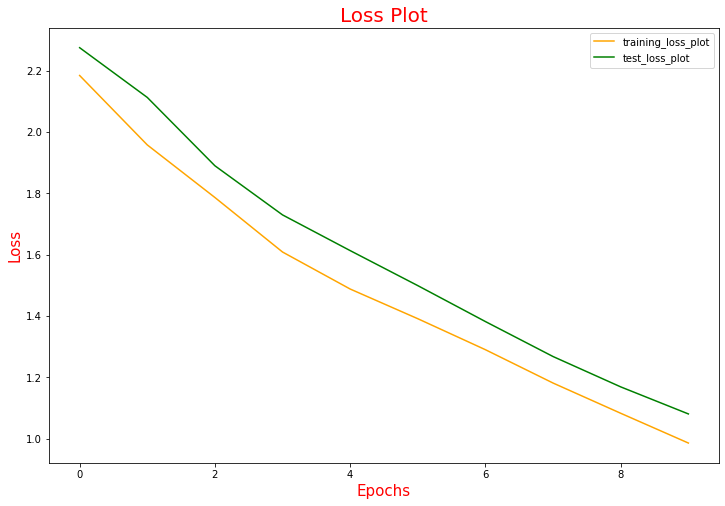

In [215]:
from matplotlib.pyplot import figure
figure(figsize=(12, 8))
plt.plot(loss_plot, color='orange', label = 'training_loss_plot')
plt.plot(test_loss_plot, color='green', label = 'test_loss_plot')
plt.xlabel('Epochs', fontsize = 15, color = 'red')
plt.ylabel('Loss', fontsize = 15, color = 'red')
plt.title('Loss Plot', fontsize = 20, color = 'red')
plt.legend()
plt.show()

In [216]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_feature_shape))

    hidden = decoder.init_state(batch_size=1)

    temp_input = tf.expand_dims(load_images(image)[0], 0) 
    img_tensor_val = image_features_extract_model(temp_input) 
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder (img_tensor_val) 

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden) 
        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.argmax(predictions[0]).numpy() 
        result.append (tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot,predictions

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot,predictions

In [257]:
def plot_attention_map (caption, weights, image) :

  fig = plt.figure(figsize = (20, 20))
  temp_img = np.array(Image.open(image))

  cap_len = len(caption)
  for cap in range(cap_len) :
    weights_img = np.reshape(weights[cap], (8,8))
    wweights_img = np.array(Image.fromarray(weights_img).resize((224,224), Image.LANCZOS))

    ax = fig.add_subplot(cap_len//2, cap_len//2, cap+1)
    ax.set_title(caption[cap], fontsize = 14, color = 'red')

    img = ax.imshow(temp_img)

    ax.imshow(weights_img, cmap='gist_heat', alpha=0.6, extent=img.get_extent())
    ax.axis('off')
  plt.subplots_adjust(hspace=0.2, wspace=0.2)
  plt.show()

In [218]:
from nltk.translate.bleu_score import sentence_bleu

In [219]:
def filt_text(text):
    filt=['<start>','<unk>','<end>'] 
    temp= text.split()
    [temp.remove(j) for k in filt for j in temp if k==j]
    text=' '.join(temp)
    return text

In [220]:
image_test = path_test.copy()

In [268]:
def pred_caption(random, weights=(0.5, 0.5, 0, 0)) :

    cap_test_data = caption_test.copy()
    rid = np.random.randint(0, random)
    test_image = image_test[rid]
    real_caption = ' '.join([tokenizer.index_word[i] for i in cap_test_data[rid] if i not in [0]])
    result, attention_plot, pred_test = evaluate(test_image)
    real_caption=filt_text(real_caption)      
    pred_caption=' '.join(result).rsplit(' ', 1)[0]
    real_appn = []
    real_appn.append(real_caption.split())
    reference = real_appn
    candidate = pred_caption.split()
    score = sentence_bleu(reference, candidate, weights=weights)#set your weights
    print(f"BLEU score: {score*100}")
    print ('Real Caption:', real_caption)
    print ('Prediction Caption:', pred_caption)
    plot_attention_map(result, attention_plot, test_image)
    return test_image

BLEU score: 5.737507141266155
Real Caption: two dogs are shaking off water while playing with ball on the edge of body of water
Prediction Caption: two dogs shaking the beach


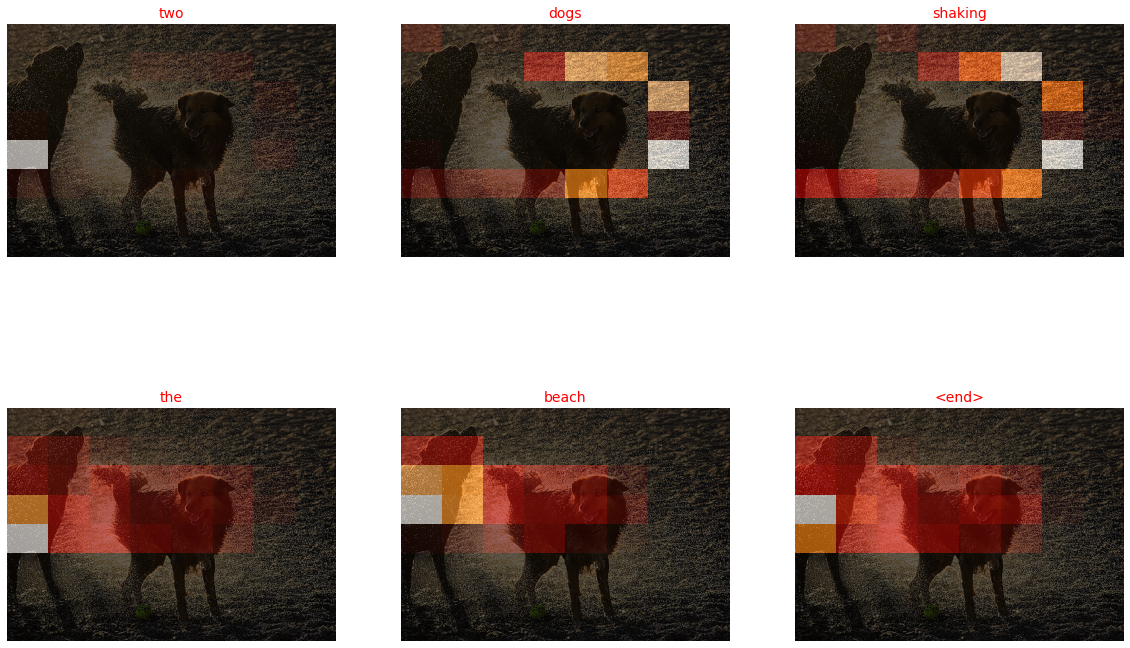

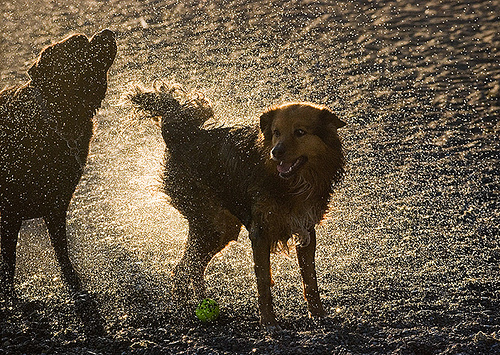

In [269]:
test_image = pred_caption(len(image_test), weights = (0.5, 0.25, 0, 0))
Image.open(test_image)